<a href="https://colab.research.google.com/github/byeongdon/hanghae99/blob/main/1%EC%A3%BC%EC%B0%A8_%EC%8B%AC%ED%99%94%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST CIFAR-10 차이점(from GPT)

MNIST는 데이터가 너무 단순해서 대부분의 모델이 **거의 완벽한 정확도(>99%)**를 내요. 그래서:

Optimizer 차이가 드러나지 않고,

Activation function에 따른 변화도 미미하며,

Dropout 같은 regularization 기법도 거의 영향이 없을 수 있어요.

반면에 CIFAR-10은 진짜로:

다양한 시각적 패턴이 존재하고,

모델이 과적합(overfitting) 되기 쉬우며,

일반화 성능 차이가 확실하게 나타나요.

# 🔍 실험 항목별로 왜 중요한지 정리
1. SGD vs Adam
CIFAR-10처럼 복잡한 이미지 분류 문제에서는 Adam이 수렴 속도가 빠르고, 초반 성능이 뛰어남.

하지만 SGD + momentum이 더 나은 일반화 성능을 보일 수도 있어요.

⇒ 실험을 통해 trade-off를 직접 확인 가능

2. Leaky ReLU vs Sigmoid
Sigmoid는 gradient vanishing 문제로 깊은 네트워크에서는 거의 사용되지 않아요.

Leaky ReLU는 **죽은 뉴런 문제(dead neuron)**를 완화하고 더 나은 성능을 냅니다.

⇒ CIFAR-10에서는 이런 차이가 성능 격차로 드러납니다.

3. Dropout 적용 전후 Generalization Error
Dropout은 과적합을 줄이고 **훈련 vs 테스트 성능 차이(gap)**를 줄이기 위해 사용돼요.

MNIST는 과적합 자체가 잘 안 일어나서 효과를 보기 어렵지만,

CIFAR-10에서는 Dropout 유무에 따른 일반화 성능 차이가 명확히 보입니다.


In [17]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

In [18]:
transform = transforms.ToTensor()
batch_size = 256

trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False
)

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True
)

50000
torch.Size([3, 32, 32]) 6


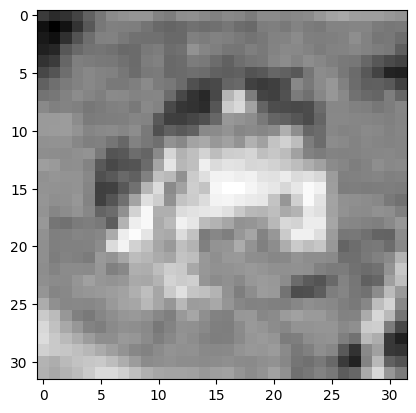

In [19]:
from matplotlib import pyplot as plt


print(len(trainset))
print(trainset[0][0].shape, trainset[0][1])
plt.imshow(trainset[0][0][0], cmap='gray')

In [20]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([256, 3, 32, 32]) torch.Size([256])


In [21]:
from torch import nn


class Model(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10)

    self.act = nn.LeakyReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.act(self.layer3(x))

    return x


model = Model(32 * 32 * 3, 1024)

In [22]:
def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

In [23]:
from torch.optim import SGD,Adam


lr = 0.001
n_epochs = 50
model = model.to('cuda')

SGD_optimizer = SGD(model.parameters(), lr=lr)
lose_fn = nn.CrossEntropyLoss()

SGD_train_accs = []
Adam_train_accs = []
Adam_test_accs = []

# SGD
for epoch in range(n_epochs):
  total_loss = 0.
  for data in trainloader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    #loss = (preds[:, 0] - labels).pow(2).mean()
    loss = lose_fn(preds, labels)
    loss.backward()
    SGD_optimizer.step()

    total_loss += loss.item()

  SGD_train_accs.append(accuracy(model, trainloader))

  print(f"Epoch {epoch:3d} | Loss: {total_loss}")

# Adam
Adam_optimizer = Adam(model.parameters(), lr=lr)
for epoch in range(n_epochs):
  total_loss = 0.
  for data in trainloader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    #loss = (preds[:, 0] - labels).pow(2).mean()
    loss = lose_fn(preds, labels)
    loss.backward()
    Adam_optimizer.step()

    total_loss += loss.item()

  Adam_train_accs.append(accuracy(model, trainloader))
  Adam_test_accs.append(accuracy(model, testloader))

  print(f"Epoch {epoch:3d} | Loss: {total_loss}")




Epoch   0 | Loss: 450.985089302063
Epoch   1 | Loss: 449.75450110435486
Epoch   2 | Loss: 448.77099108695984
Epoch   3 | Loss: 447.8872334957123
Epoch   4 | Loss: 446.4904828071594
Epoch   5 | Loss: 445.0173795223236
Epoch   6 | Loss: 443.6016538143158
Epoch   7 | Loss: 442.1922233104706
Epoch   8 | Loss: 440.76296401023865
Epoch   9 | Loss: 439.2981607913971
Epoch  10 | Loss: 437.8039560317993
Epoch  11 | Loss: 436.3028619289398
Epoch  12 | Loss: 434.8209390640259
Epoch  13 | Loss: 433.338632106781
Epoch  14 | Loss: 431.85849928855896
Epoch  15 | Loss: 430.4512765407562
Epoch  16 | Loss: 429.04317569732666
Epoch  17 | Loss: 427.69741797447205
Epoch  18 | Loss: 426.4165771007538
Epoch  19 | Loss: 425.162273645401
Epoch  20 | Loss: 423.9764506816864
Epoch  21 | Loss: 422.75330114364624
Epoch  22 | Loss: 421.69735741615295
Epoch  23 | Loss: 420.76547026634216
Epoch  24 | Loss: 419.80267238616943
Epoch  25 | Loss: 418.8253960609436
Epoch  26 | Loss: 417.97314715385437
Epoch  27 | Loss: 41

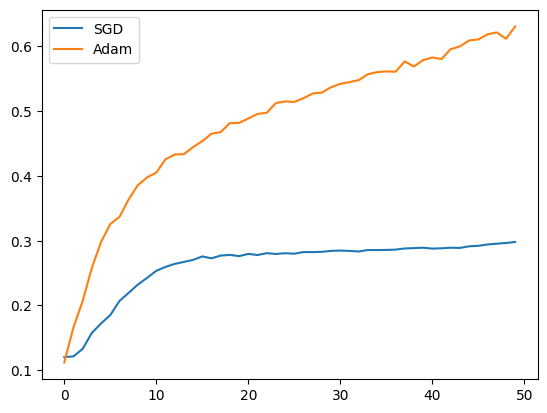

In [24]:
def plot_acc(SGD_train_accs, Adam_train_accs, label1, label2):
  x = np.arange(len(SGD_train_accs))
  y = np.arange(len(Adam_train_accs))

  plt.plot(x, SGD_train_accs, label=label1)
  plt.plot(y, Adam_train_accs, label=label2)
  plt.legend()
  plt.show()

plot_acc(SGD_train_accs,Adam_train_accs, 'SGD', 'Adam')

In [25]:
class Model2(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10)

    self.act = nn.Sigmoid()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.act(self.layer3(x))

    return x


model = Model2(32 * 32 * 3, 1024)

Epoch   0 | Loss: 411.7358024120331
Epoch   1 | Loss: 395.47955203056335
Epoch   2 | Loss: 387.43653178215027
Epoch   3 | Loss: 384.18178033828735
Epoch   4 | Loss: 381.49859261512756
Epoch   5 | Loss: 379.4858865737915
Epoch   6 | Loss: 377.63728737831116
Epoch   7 | Loss: 375.76130175590515
Epoch   8 | Loss: 374.06667125225067
Epoch   9 | Loss: 372.7597955465317
Epoch  10 | Loss: 371.99187886714935
Epoch  11 | Loss: 370.1219183206558
Epoch  12 | Loss: 369.10802459716797
Epoch  13 | Loss: 368.5913722515106
Epoch  14 | Loss: 367.67675817012787
Epoch  15 | Loss: 367.3884688615799
Epoch  16 | Loss: 366.205073595047
Epoch  17 | Loss: 365.9779462814331
Epoch  18 | Loss: 364.90113604068756
Epoch  19 | Loss: 364.5002804994583
Epoch  20 | Loss: 363.75139105319977
Epoch  21 | Loss: 363.7377451658249
Epoch  22 | Loss: 363.1669055223465
Epoch  23 | Loss: 362.7860687971115
Epoch  24 | Loss: 362.1954678297043
Epoch  25 | Loss: 361.5468566417694
Epoch  26 | Loss: 360.9575501680374
Epoch  27 | Loss:

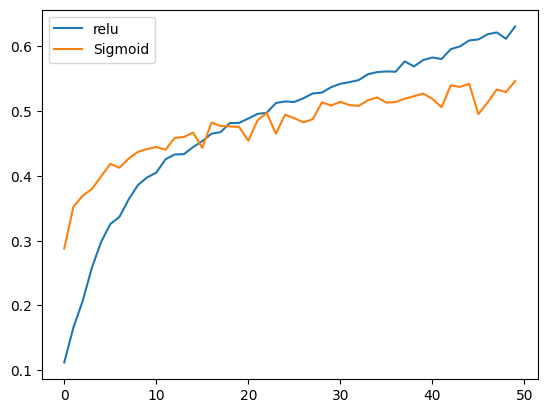

In [26]:
from torch.optim import Adam


lr = 0.001
n_epochs = 50
model = model.to('cuda')

Sigmoid_train_accs = []

Adam_optimizer = Adam(model.parameters(), lr=lr)
for epoch in range(n_epochs):
  total_loss = 0.
  for data in trainloader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    #loss = (preds[:, 0] - labels).pow(2).mean()
    loss = lose_fn(preds, labels)
    loss.backward()
    Adam_optimizer.step()

    total_loss += loss.item()

  Sigmoid_train_accs.append(accuracy(model, trainloader))

  print(f"Epoch {epoch:3d} | Loss: {total_loss}")

plot_acc(Adam_train_accs,Sigmoid_train_accs,'relu', 'Sigmoid')

In [27]:
class Model3(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10)

    self.act = nn.LeakyReLU()
    self.dropout = 0.1

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.act(self.layer3(x))

    return x




In [28]:
model = Model3(32 * 32 * 3, 1024)
model = model.to('cuda')
n_epochs = 50

optimizer = Adam(model.parameters(), lr=lr)
train_dropout = []
test_dropout = []

for epoch in range(n_epochs):
  total_loss = 0.
  model.train()
  for data in trainloader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    #loss = (preds[:, 0] - labels).pow(2).mean()
    loss = lose_fn(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  with torch.no_grad():
    model.eval()
    train_dropout.append(accuracy(model, trainloader))
    test_dropout.append(accuracy(model, testloader))

  print(f"Epoch {epoch:3d} | Loss: {total_loss}")


Epoch   0 | Loss: 422.49790477752686
Epoch   1 | Loss: 383.61919915676117
Epoch   2 | Loss: 362.01251661777496
Epoch   3 | Loss: 344.7359335422516
Epoch   4 | Loss: 334.79288375377655
Epoch   5 | Loss: 323.4064863920212
Epoch   6 | Loss: 314.07529389858246
Epoch   7 | Loss: 307.0449186563492
Epoch   8 | Loss: 301.84754288196564
Epoch   9 | Loss: 294.84787774086
Epoch  10 | Loss: 291.8619190454483
Epoch  11 | Loss: 286.4416415691376
Epoch  12 | Loss: 282.2058606147766
Epoch  13 | Loss: 278.37726867198944
Epoch  14 | Loss: 274.71383023262024
Epoch  15 | Loss: 270.40477669239044
Epoch  16 | Loss: 267.52684211730957
Epoch  17 | Loss: 262.9168643951416
Epoch  18 | Loss: 262.85021448135376
Epoch  19 | Loss: 256.5290651321411
Epoch  20 | Loss: 253.78711891174316
Epoch  21 | Loss: 249.92454731464386
Epoch  22 | Loss: 247.24354112148285
Epoch  23 | Loss: 245.28547954559326
Epoch  24 | Loss: 239.81597661972046
Epoch  25 | Loss: 236.39290285110474
Epoch  26 | Loss: 234.82790005207062
Epoch  27 | 

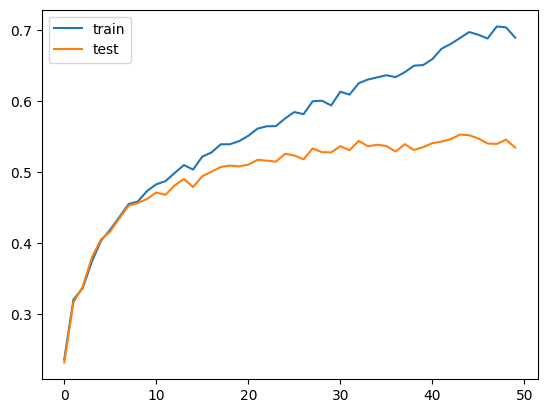

In [29]:
plot_acc(train_dropout,test_dropout,'train','test')